http://www.astro.cornell.edu/research/projects/compression/entropy.html
Image entropy is a quantity which is used to describe the `business' of an image, i.e. the amount of information which must be coded for by a compression algorithm. Low entropy images, such as those containing a lot of black sky, have very little contrast and large runs of pixels with the same or similar DN values. An image that is perfectly flat will have an entropy of zero. Consequently, they can be compressed to a relatively small size. On the other hand, high entropy images such as an image of heavily cratered areas on the moon have a great deal of contrast from one pixel to the next and consequently cannot be compressed as much as low entropy images.

## Imports

In [1]:
from glob import glob
import json
import numpy as np
import pandas as pd
import PIL

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set_style("dark", {'axes.grid' : False})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load merge data

In [2]:
app_ui_df = pd.read_pickle('clean_data/app_ui_df.pkl')
app_ui_df.shape

(9567, 17)

In [3]:
app_ui_df.head()

,app_package_name,app_name,app_category,star_rating,average_rating,number_of_ratings,min_ratings,ui_number,interaction_trace_number,ui_number_in_trace,filename,app_name_num,app_cat_num,star_rating_num,average_rating_num,number_of_ratings_num,filename_num
0,B4A.BigFivePersonalityTest,[Big 5 Personality Test],Education,[3.6],[6698],"[ 1,000,000 - 5,000,000 ]",[1000000],[49783],[0],[221],[app_uis/49783.jpg],1,1,1,1,1,1
1,CN.MyPrivateMessages,[Calculator],Communication,[4.3],"[17020, 16918, 16919]","[ 1,000,000 - 5,000,000 ]",[1000000],[26083],[0],[15],[app_uis/26083.jpg],1,1,1,3,1,1
2,DOCECG2.doctor,[Electrocardiogram ECG Types],Medical,[3.9],"[4134, 4135]","[ 500,000 - 1,000,000 ]",[500000],[51036],[0],[58],[app_uis/51036.jpg],1,1,1,2,1,1
3,Gecko.Droid.PhysicsHelper,[Pocket Physics],Education,[4.1],[15938],"[ 1,000,000 - 5,000,000 ]",[1000000],"[29868, 29869, 21237, 21238, 21239]","[0, 2]","[194, 269, 1361, 370, 285]","[app_uis/21238.jpg, app_uis/21237.jpg, app_uis...",1,1,1,1,1,5
4,HinKhoj.Dictionary,[English Hindi Dictionary],Books & Reference,[4.3],"[246778, 247420]","[ 10,000,000 - 50,000,000 ]",[10000000],"[42080, 42081, 42082, 42083, 42084, 42085, 420...",[1],"[864, 324, 741, 710, 132, 261, 876, 972, 654, ...","[app_uis/42075.jpg, app_uis/42082.jpg, app_uis...",1,1,1,2,1,20


#### Subset to only columns of interest

In [4]:
app_ui_df['star_rating_ave'] = app_ui_df.star_rating.map(lambda x: np.mean(x))
app_ui_df['average_rating_ave'] = app_ui_df.average_rating.map(lambda x: np.mean(x))
app_ui_df['min_ratings_ave'] = app_ui_df.min_ratings.map(lambda x: np.mean(x))

In [5]:
cols_keep = ['app_package_name', 'app_name', 'app_category', 'star_rating_ave', \
             'average_rating_ave', 'min_ratings_ave', 'filename', 'filename_num']

app_ui_df_clean = app_ui_df[cols_keep]

In [6]:
app_ui_df_clean.head()

,app_package_name,app_name,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename,filename_num
0,B4A.BigFivePersonalityTest,[Big 5 Personality Test],Education,3.6,6698.000000,1000000.0,[app_uis/49783.jpg],1
1,CN.MyPrivateMessages,[Calculator],Communication,4.3,16952.333333,1000000.0,[app_uis/26083.jpg],1
2,DOCECG2.doctor,[Electrocardiogram ECG Types],Medical,3.9,4134.500000,500000.0,[app_uis/51036.jpg],1
3,Gecko.Droid.PhysicsHelper,[Pocket Physics],Education,4.1,15938.000000,1000000.0,"[app_uis/21238.jpg, app_uis/21237.jpg, app_uis...",5
4,HinKhoj.Dictionary,[English Hindi Dictionary],Books & Reference,4.3,247099.000000,10000000.0,"[app_uis/42075.jpg, app_uis/42082.jpg, app_uis...",20


In [7]:
filename_exp = app_ui_df_clean.filename.apply(pd.Series).stack().reset_index(
    level=1, drop=True).to_frame('filename_exp')

In [8]:
filename_exp.shape

(70959, 1)

In [9]:
app_ui_exp = pd.concat([app_ui_df_clean, filename_exp], axis=1)

In [10]:
app_ui_exp.shape

(70959, 9)

In [11]:
app_ui_exp.head()

,app_package_name,app_name,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename,filename_num,filename_exp
0,B4A.BigFivePersonalityTest,[Big 5 Personality Test],Education,3.6,6698.000000,1000000.0,[app_uis/49783.jpg],1,app_uis/49783.jpg
1,CN.MyPrivateMessages,[Calculator],Communication,4.3,16952.333333,1000000.0,[app_uis/26083.jpg],1,app_uis/26083.jpg
2,DOCECG2.doctor,[Electrocardiogram ECG Types],Medical,3.9,4134.500000,500000.0,[app_uis/51036.jpg],1,app_uis/51036.jpg
3,Gecko.Droid.PhysicsHelper,[Pocket Physics],Education,4.1,15938.000000,1000000.0,"[app_uis/21238.jpg, app_uis/21237.jpg, app_uis...",5,app_uis/21238.jpg
3,Gecko.Droid.PhysicsHelper,[Pocket Physics],Education,4.1,15938.000000,1000000.0,"[app_uis/21238.jpg, app_uis/21237.jpg, app_uis...",5,app_uis/21237.jpg


In [12]:
app_ui_exp.reset_index(drop=True, inplace=True)

In [13]:
app_ui_exp.head()

,app_package_name,app_name,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename,filename_num,filename_exp
0,B4A.BigFivePersonalityTest,[Big 5 Personality Test],Education,3.6,6698.000000,1000000.0,[app_uis/49783.jpg],1,app_uis/49783.jpg
1,CN.MyPrivateMessages,[Calculator],Communication,4.3,16952.333333,1000000.0,[app_uis/26083.jpg],1,app_uis/26083.jpg
2,DOCECG2.doctor,[Electrocardiogram ECG Types],Medical,3.9,4134.500000,500000.0,[app_uis/51036.jpg],1,app_uis/51036.jpg
3,Gecko.Droid.PhysicsHelper,[Pocket Physics],Education,4.1,15938.000000,1000000.0,"[app_uis/21238.jpg, app_uis/21237.jpg, app_uis...",5,app_uis/21238.jpg
4,Gecko.Droid.PhysicsHelper,[Pocket Physics],Education,4.1,15938.000000,1000000.0,"[app_uis/21238.jpg, app_uis/21237.jpg, app_uis...",5,app_uis/21237.jpg


In [14]:
app_ui_exp.groupby('app_package_name')['app_package_name'].count().shape

(9567,)

In [17]:
app_ui_exp.groupby('app_package_name')['app_package_name'].count().head()

app_package_name
B4A.BigFivePersonalityTest     1
CN.MyPrivateMessages           1
DOCECG2.doctor                 1
Gecko.Droid.PhysicsHelper      5
HinKhoj.Dictionary            20
Name: app_package_name, dtype: int64

In [24]:
app_ui_exp.rename(columns={'filename': 'filename_list'}, inplace=True)

In [25]:
app_ui_exp.head()

,app_package_name,app_name,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp
0,B4A.BigFivePersonalityTest,[Big 5 Personality Test],Education,3.6,6698.000000,1000000.0,[app_uis/49783.jpg],1,app_uis/49783.jpg
1,CN.MyPrivateMessages,[Calculator],Communication,4.3,16952.333333,1000000.0,[app_uis/26083.jpg],1,app_uis/26083.jpg
2,DOCECG2.doctor,[Electrocardiogram ECG Types],Medical,3.9,4134.500000,500000.0,[app_uis/51036.jpg],1,app_uis/51036.jpg
3,Gecko.Droid.PhysicsHelper,[Pocket Physics],Education,4.1,15938.000000,1000000.0,"[app_uis/21238.jpg, app_uis/21237.jpg, app_uis...",5,app_uis/21238.jpg
4,Gecko.Droid.PhysicsHelper,[Pocket Physics],Education,4.1,15938.000000,1000000.0,"[app_uis/21238.jpg, app_uis/21237.jpg, app_uis...",5,app_uis/21237.jpg


#### Stats on UI screenshots associated with each app package

In [18]:
app_ui_df.filename_num.describe()

count    9567.000000
mean        7.417059
std         7.603794
min         1.000000
25%         2.000000
50%         5.000000
75%        10.000000
max        76.000000
Name: filename_num, dtype: float64

In [26]:
app_ui_exp['img_w'] = app_ui_exp.filename_exp.map(lambda x: PIL.Image.open(x).size[0])

In [30]:
app_ui_exp['img_h'] = app_ui_exp.filename_exp.map(lambda x: PIL.Image.open(x).size[1])

In [34]:
app_ui_exp['aspect_ratio'] = (app_ui_exp.img_w / app_ui_exp.img_h)

In [41]:
app_ui_exp['portrait_ort'] = app_ui_exp.aspect_ratio.map(lambda x: 0 if x < 1.0 else 1)

In [42]:
app_ui_exp.head()

,app_package_name,app_name,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio,portrait_ort
0,B4A.BigFivePersonalityTest,[Big 5 Personality Test],Education,3.6,6698.000000,1000000.0,[app_uis/49783.jpg],1,app_uis/49783.jpg,1080,1920,0.5625,0
1,CN.MyPrivateMessages,[Calculator],Communication,4.3,16952.333333,1000000.0,[app_uis/26083.jpg],1,app_uis/26083.jpg,1080,1920,0.5625,0
2,DOCECG2.doctor,[Electrocardiogram ECG Types],Medical,3.9,4134.500000,500000.0,[app_uis/51036.jpg],1,app_uis/51036.jpg,1080,1920,0.5625,0
3,Gecko.Droid.PhysicsHelper,[Pocket Physics],Education,4.1,15938.000000,1000000.0,"[app_uis/21238.jpg, app_uis/21237.jpg, app_uis...",5,app_uis/21238.jpg,540,960,0.5625,0
4,Gecko.Droid.PhysicsHelper,[Pocket Physics],Education,4.1,15938.000000,1000000.0,"[app_uis/21238.jpg, app_uis/21237.jpg, app_uis...",5,app_uis/21237.jpg,540,960,0.5625,0


In [49]:
app_ui_exp.img_w.value_counts()

1080    53899
540     16949
1920       82
960        29
Name: img_w, dtype: int64

In [48]:
app_ui_exp.img_h.value_counts()

1920    53899
960     16949
1080       82
540        29
Name: img_h, dtype: int64

In [50]:
app_ui_exp.portrait_ort.value_counts()

0    70848
1      111
Name: portrait_ort, dtype: int64

In [52]:
demo_img = PIL.Image.open(app_ui_exp.filename_exp[0])

In [54]:
len(demo_img.histogram())

768

In [62]:
demo_img.histogram()[0:255]

[173214,
 4171,
 5082,
 1391,
 4790,
 1464,
 1628,
 2150,
 1885,
 937,
 1939,
 1418,
 467,
 426,
 868,
 1410,
 299,
 299,
 254,
 1295,
 218,
 177,
 183,
 195,
 187,
 151,
 146,
 140,
 129,
 159,
 140,
 124,
 154,
 151,
 143,
 148,
 144,
 124,
 137,
 108,
 135,
 108,
 1176,
 127,
 127,
 118,
 131,
 125,
 135,
 96,
 132,
 99,
 170,
 98,
 161,
 163,
 123,
 179,
 185,
 207,
 191,
 271,
 279,
 248,
 380,
 415,
 1598,
 354,
 693,
 785,
 461,
 1865,
 2985,
 856,
 415,
 979,
 4323,
 457,
 1116,
 174476,
 2268,
 401,
 2234,
 932,
 385,
 877,
 1874,
 1856,
 371,
 2235,
 592,
 431,
 620,
 675,
 1918,
 735,
 841,
 1719,
 2829,
 1766,
 561,
 112933,
 1359,
 400,
 223,
 1374,
 262,
 229,
 203,
 212,
 236,
 196,
 385,
 183,
 170,
 159,
 152,
 374,
 180,
 134,
 341,
 1188,
 109,
 602,
 138,
 152,
 131,
 109,
 138,
 122,
 185,
 288,
 207,
 114,
 106,
 115,
 97,
 119,
 1186,
 115,
 133,
 81,
 94,
 101,
 112,
 149,
 106,
 98,
 93,
 99,
 92,
 100,
 120,
 140,
 122,
 2402,
 125,
 107,
 100,
 122,
 112,
 12

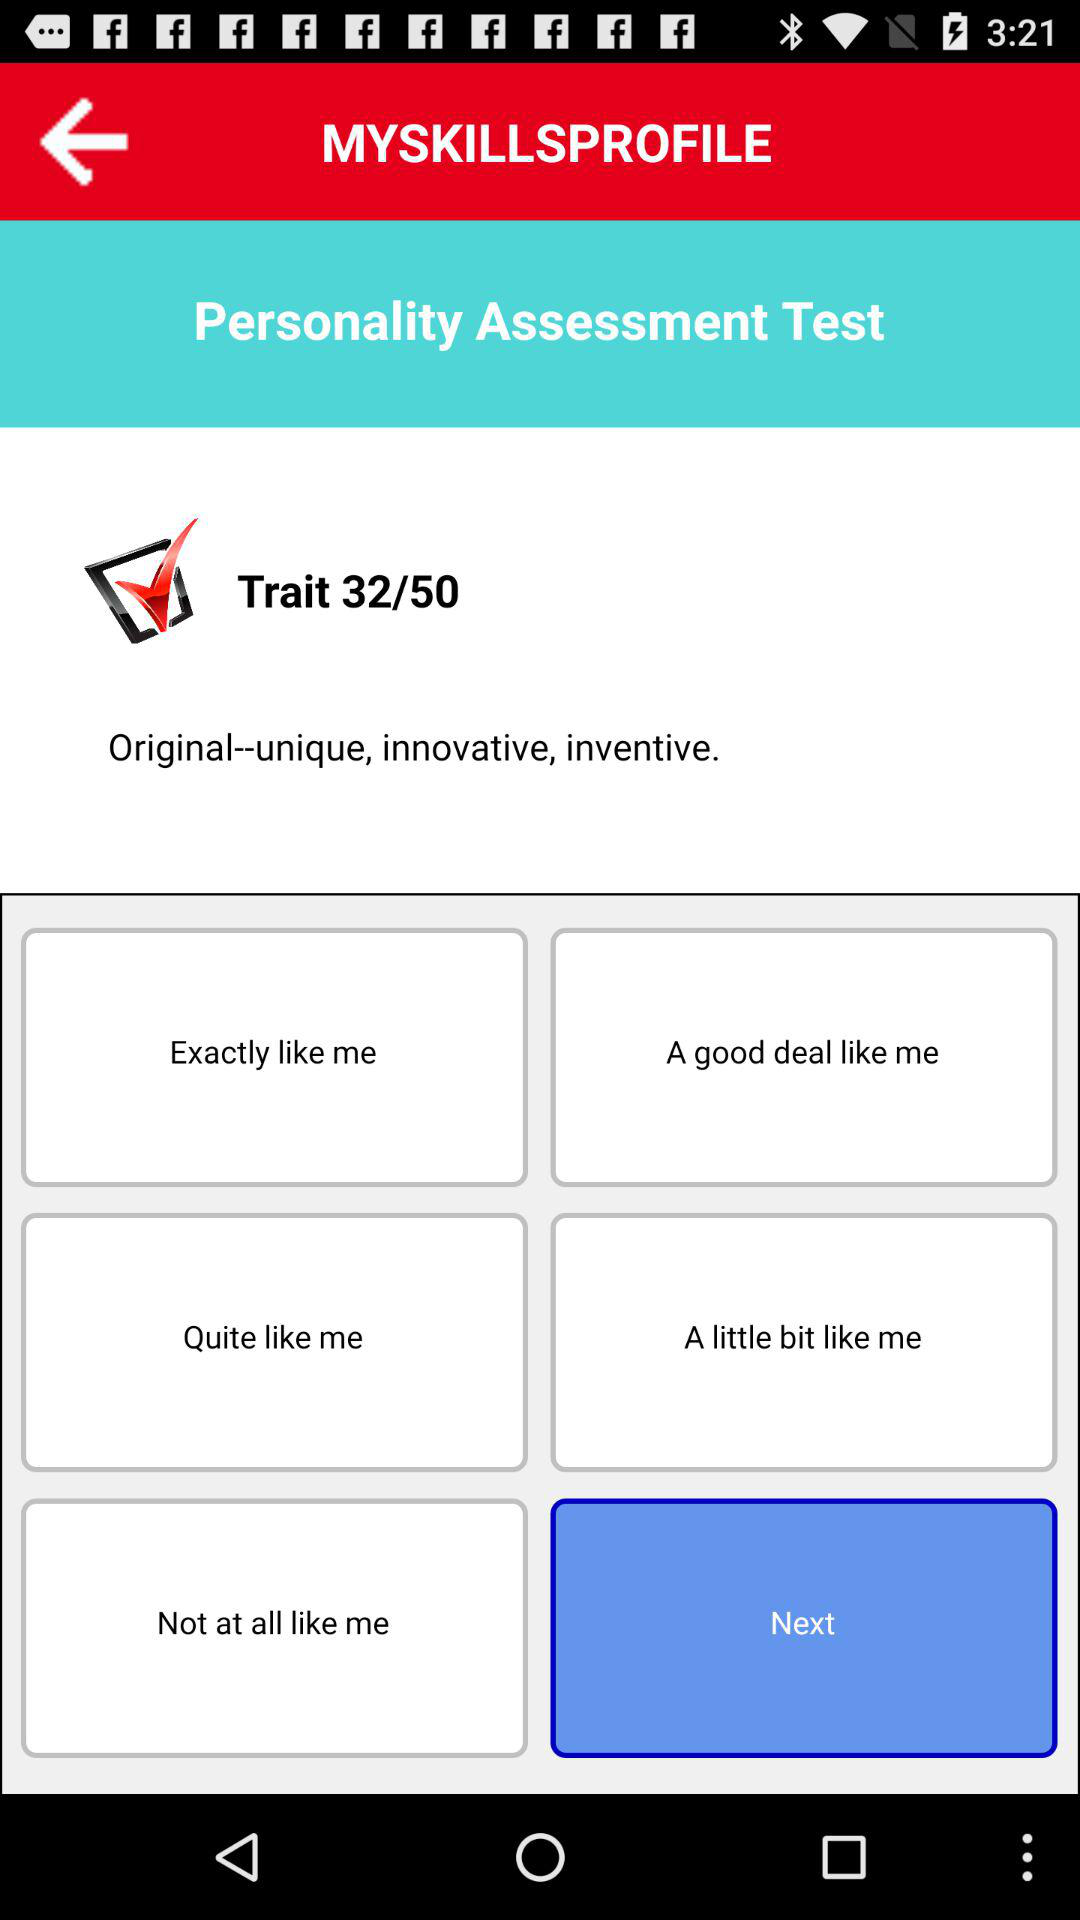

In [64]:
demo_img

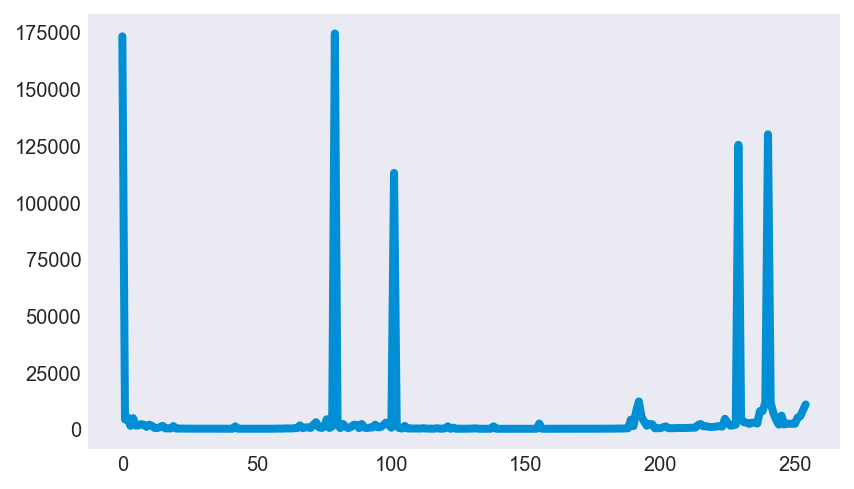

In [63]:
plt.plot(demo_img.histogram()[0:255])

(0.5, 1079.5, 0.5, 1919.5)

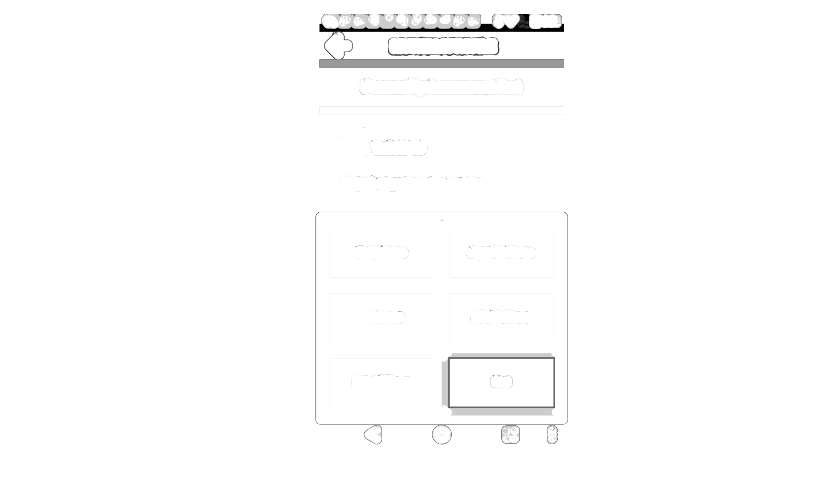

In [70]:
from pylab import *

# read image to array
im = array(demo_img.convert('L'))

# create a new figure
figure()
# don't use colors
gray()
# show contours with origin upper left corner
contour(im, origin='image')
axis('equal')
axis('off')

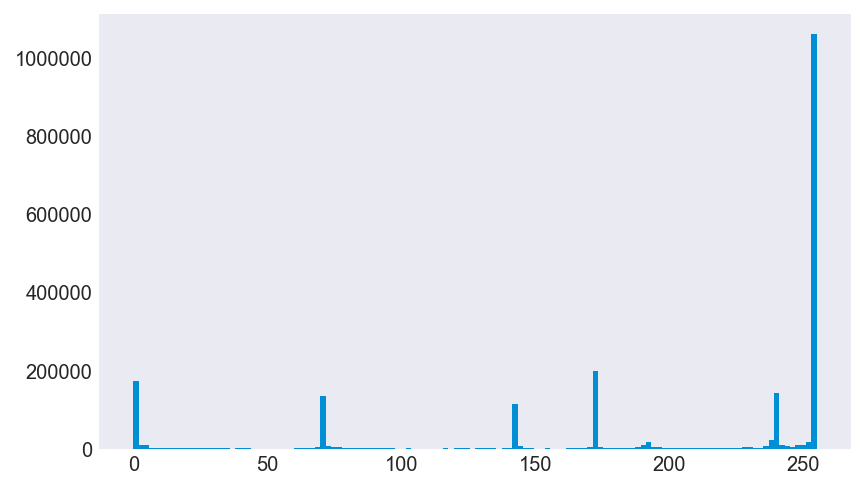

In [71]:
figure()
hist(im.flatten(),128)
show()

In [73]:
img = PIL.Image.open(app_ui_exp.filename_exp[0])

In [74]:
r, g, b = img.split()

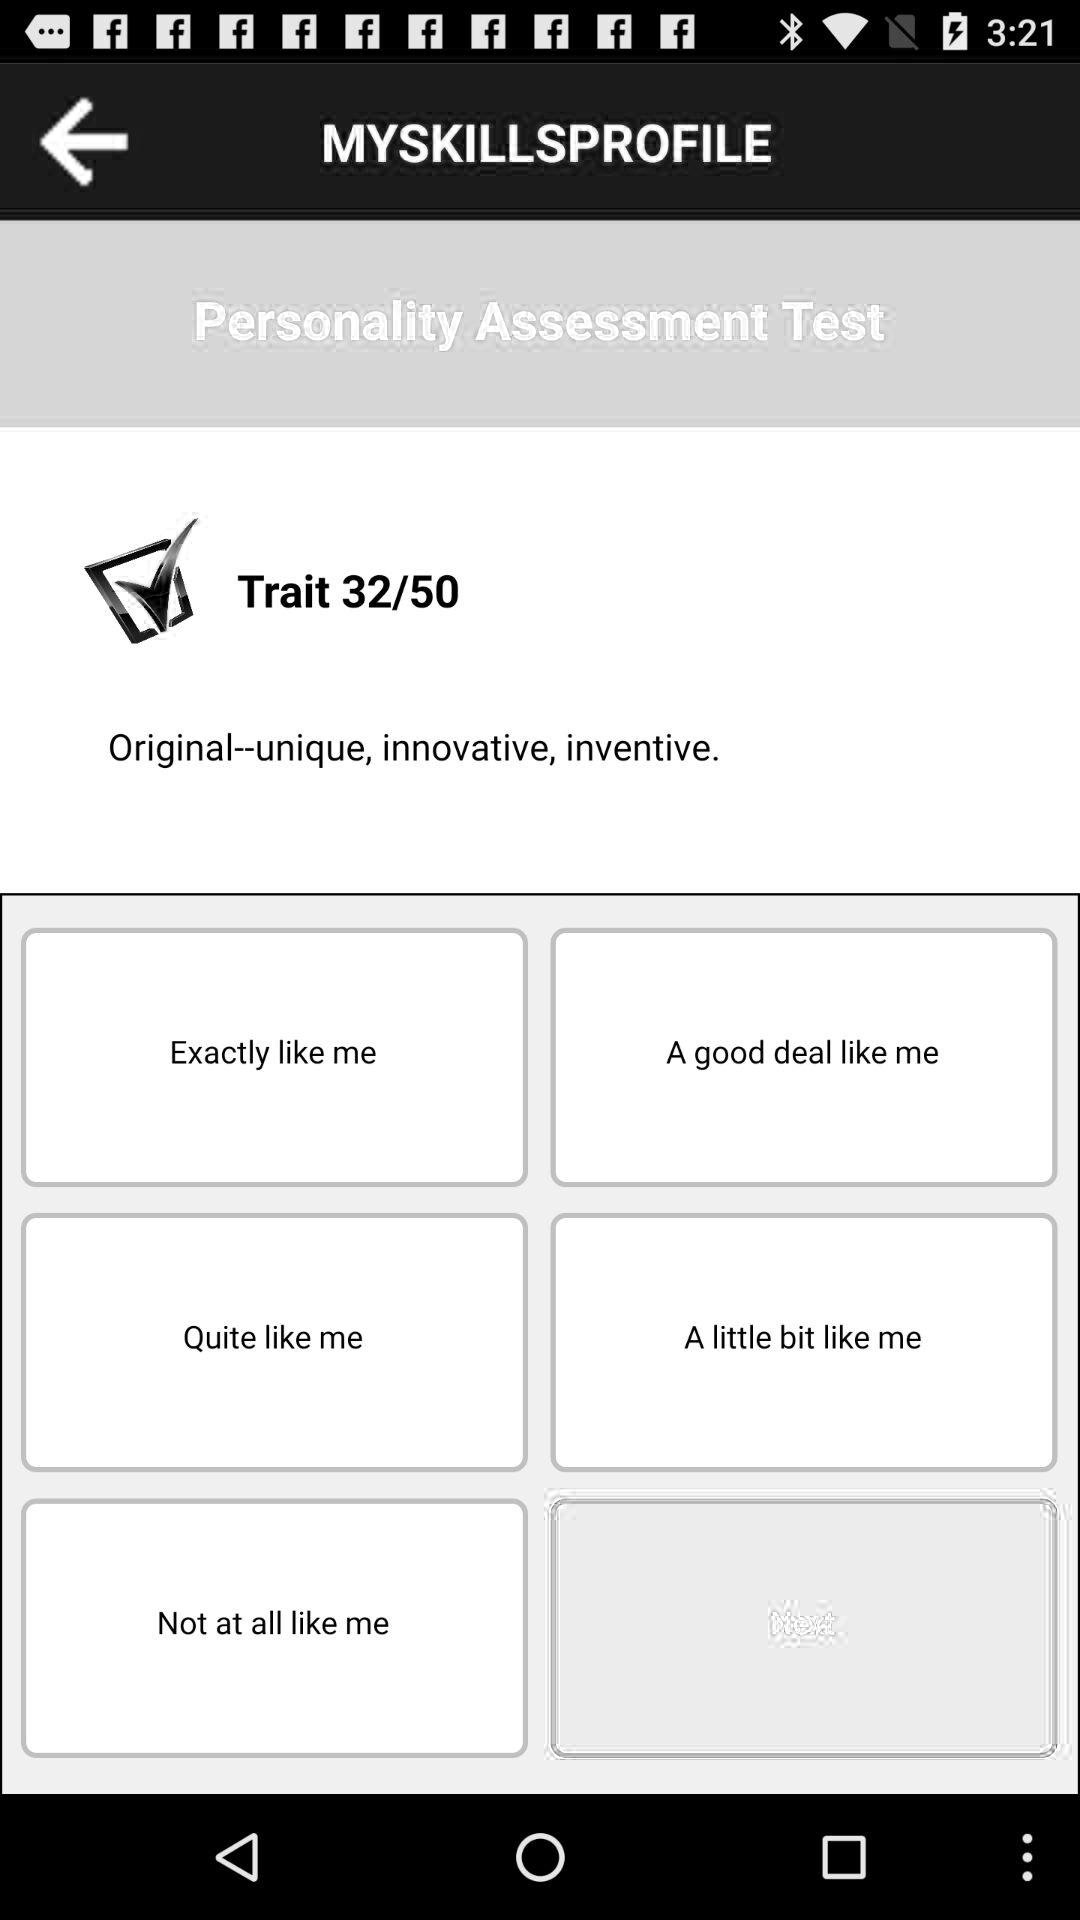

In [77]:
b

In [ ]:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html

https://books.google.com/books?id=VK2eBQAAQBAJ&pg=PA5&lpg=PA5&dq=joint+probability+of+red+green+blue+pixels+in+an+image&source=bl&ots=8hQjzgAfVr&sig=KWuupOF9o_y649Ze6-nVQQ6RB5M&hl=en&sa=X&ved=0ahUKEwiUpuDMz4PYAhVB7IMKHYVYBrcQ6AEINDAD#v=onepage&q=joint%20probability%20of%20red%20green%20blue%20pixels%20in%20an%20image&f=false
An image histogram refers to the probability mass function of the image intensities.
This is extended for color images to capture the joint probabilities of the intensities of the three-color channels.

https://books.google.com/books?id=IO75BwAAQBAJ&pg=PA138&lpg=PA138&dq=joint+probability+of+red+green+blue+pixels+in+an+image&source=bl&ots=zcrkJ-M5bE&sig=xrCbrx13haux6dSXEPDbxyr6rJU&hl=en&sa=X&ved=0ahUKEwiUpuDMz4PYAhVB7IMKHYVYBrcQ6AEIKTAA#v=onepage&q=joint%20probability%20of%20red%20green%20blue%20pixels%20in%20an%20image&f=false

Color histogram is a joint probability distribution of the number of pixels in the image in each band (R,G,B)

Standard deviation gives idea about image contrast. High standard deviation means high image contrast.

In [65]:
w, h = demo_img.size  
colors = im.getcolors(w*h) 

In [66]:
colors

[(30720, (51, 51, 51, 255))]

In [60]:


imagepath = app_ui_exp.filename_exp[0]  # The image to build the histogram of


histHeight = 120            # Height of the histogram
histWidth = 256             # Width of the histogram
multiplerValue = 1.5        # The multiplier value basically increases
                            # the histogram height so that love values
                            # are easier to see, this in effect chops off
                            # the top of the histogram.
showFstopLines = True       # True/False to hide outline
fStopLines = 5


# Colours to be used
backgroundColor = (51,51,51)    # Background color
lineColor = (102,102,102)       # Line color of fStop Markers 
red = (255,60,60)               # Color for the red lines
green = (51,204,51)             # Color for the green lines
blue = (0,102,255)              # Color for the blue lines

##################################################################################


img = PIL.Image.open(imagepath)
hist = img.histogram()
histMax = max(hist)                                     # comon color
xScale = float(histWidth)/len(hist)                     # xScaling
yScale = float((histHeight)*multiplerValue)/histMax     # yScaling 


im = PIL.Image.new("RGBA", (histWidth, histHeight), backgroundColor)   
# draw = PIL.ImageDraw.Draw(im)


# # Draw Outline is required
# if showFstopLines:    
#     xmarker = histWidth/fStopLines
#     x =0
#     for i in range(1,fStopLines+1):
#         draw.line((x, 0, x, histHeight), fill=lineColor)
#         x+=xmarker
#     draw.line((histWidth-1, 0, histWidth-1, 200), fill=lineColor)
#     draw.line((0, 0, 0, histHeight), fill=lineColor)


# Draw the RGB histogram lines
x=0; c=0;
for i in hist:
    if int(i)==0: pass
    else:
        color = red
        if c>255: color = green
        if c>511: color = blue
#         draw.line((x, histHeight, x, histHeight-(i*yScale)), fill=color)        
    if x>255: x=0
    else: x+=1
    c+=1

# Now save and show the histogram    
# im.save('histogram.png', 'PNG')
im.show()